In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define Tickers
tickers = ['AAPL','MSFT','TSLA' ]
data = yf.download(tickers, start = '2020-01-01')['Close']

/tmp/ipython-input-2-1634282298.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start = '2020-01-01')['Close']
[*********************100%***********************]  3 of 3 completed


In [3]:
# Daily log returns and their Mean and Standard Deviation.
log_returns = np.log(data / data.shift(1)).dropna()
mu = log_returns.mean()
sigma = log_returns.std()
cov_matrix = log_returns.cov()

#Cholesky Decomposition for Correllation.
corr_matrix = log_returns.corr()
cholesky_matrix = np.linalg.cholesky(corr_matrix)

#Time Scaling
dt = 1/252  # time step in years
drift = (mu.values - 0.5 * sigma.values ** 2) * dt
diffusion_scale = sigma.values * np.sqrt(dt)


In [4]:
# Simulation Parameters
n_simulations = 10000
n_days = 252  # Simulate 1 trading year
initial_prices = data.iloc[-1]
weights = np.array([0.4, 0.3, 0.3])  # Portfolio weights
n_assets = len(tickers)

simulated_portfolio_values = [] # Storage of simulated portfolio values

In [5]:
# Simulation with Cholesky decomposition (annualized parameters)
dt = 1/252
# annualize your estimates
mu_ann   = mu.values   * 252
sigma_ann= sigma.values* np.sqrt(252)

drift           = (mu_ann - 0.5 * sigma_ann**2) * dt
diffusion_scale = sigma_ann * np.sqrt(dt)

simulated_portfolio_values = []
for _ in range(n_simulations):
    rand = np.random.standard_normal((n_days, n_assets))
    z = rand @ cholesky_matrix.T

    prices = np.zeros((n_days, n_assets))
    prices[0] = initial_prices
    for t in range(1, n_days):
        prices[t] = prices[t-1] * np.exp(drift + diffusion_scale * z[t])

    simulated_portfolio_values.append(weights @ prices[-1])

simulated_portfolio_values = np.array(simulated_portfolio_values)


     Expected Value     Std Dev     VaR 95%    CVaR 95%
247      436.295949  166.702014  232.479574  206.056608
248      436.767597  167.445048  232.374684  206.061022
249      437.077014  167.874631  232.756167  205.733076
250      437.598387  168.226053  234.306387  205.722488
251      438.180256  168.906987  233.368804  205.331048 



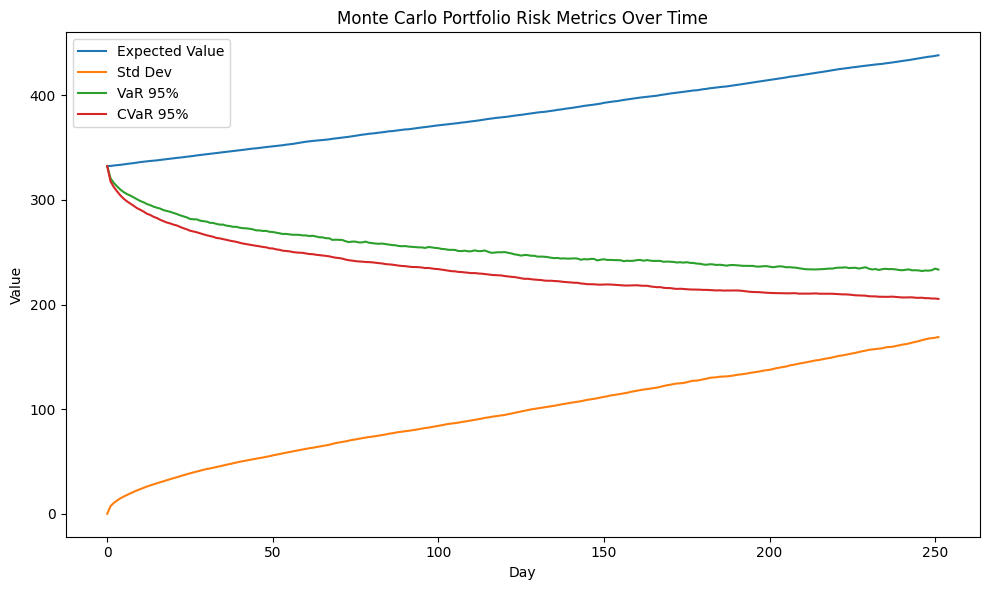

In [11]:
# Simulation over Days

# Annualize
dt              = 1/252
mu_ann          = mu.values * 252
sigma_ann       = sigma.values * np.sqrt(252)
drift           = (mu_ann - 0.5 * sigma_ann**2) * dt
diffusion_scale = sigma_ann * np.sqrt(dt)

# Pre-allocate [n_sims × n_days]
port_vals = np.zeros((n_simulations, n_days))

for i in range(n_simulations):
    # simulation
    rand = np.random.standard_normal((n_days, sigma_ann.size))
    z    = rand @ cholesky_matrix.T

    prices = np.zeros((n_days, sigma_ann.size))
    prices[0] = initial_prices.values
    for t in range(1, n_days):
        prices[t] = prices[t-1] * np.exp(drift + diffusion_scale * z[t])

    # storage by day
    port_vals[i] = prices @ weights

# ——— Compute daily metrics ———
days = np.arange(n_days)

expected_value = port_vals.mean(axis=0)                   # E[V_t]
std_dev        = port_vals.std(axis=0)                    # σ(V_t)
VaR_95         = np.percentile(port_vals, 5, axis=0)      # 5th %-ile
CVaR_95        = np.array([
    port_vals[:, t][port_vals[:, t] <= VaR_95[t]].mean()
    for t in days
])

# Combine into a DataFrame
df = pd.DataFrame({
    'Expected Value': expected_value,
    'Std Dev':        std_dev,
    'VaR 95%':        VaR_95,
    'CVaR 95%':       CVaR_95
}, index=days)

# Print the tail
print(df.tail(), "\n")

# Plot
plt.figure(figsize=(10, 6))
for col in df.columns:
    plt.plot(df.index, df[col], label=col)
plt.title("Monte Carlo Portfolio Risk Metrics Over Time")
plt.xlabel("Day")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


## 📉 Geometric Brownian Motion (GBM)

We model the price \( S_t \) of each asset using the GBM formula:

$$
S_t = S_0 \cdot \exp \left( \left( \mu - \frac{1}{2} \sigma^2 \right)t + \sigma W_t \right)
$$

Where:
- $ \mu $ is the daily expected return
- $ \sigma $ is the daily volatility
- $ W_t \sim N(0, t) $ is a standard Brownian motion


We simulate this in discrete time by sampling from a normal distribution.


In [6]:
# Calculate Risk (Today)
expected_value = np.mean(simulated_portfolio_values)
std_dev = np.std(simulated_portfolio_values)
VaR_95 = np.percentile(simulated_portfolio_values, 5)
CVaR_95 = np.mean(simulated_portfolio_values[simulated_portfolio_values <= VaR_95])

In [7]:
# Theoretical Expected Portfolio Value (Today)

# Convert inputs to NumPy arrays
init_px     = initial_prices.values
mu_ann      = mu.values * 252
sigma_ann   = sigma.values * np.sqrt(252)
w           = weights
R           = corr_matrix.values

# Time horizon
dt = 1/252
T  = n_days * dt

# 1. Theoretical expected terminal portfolio value
expected_px               = init_px * np.exp(mu_ann * T)
expected_portfolio_value  = w @ expected_px

# 2. Theoretical covariance matrix of terminal prices
n    = init_px.size
cov_T = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        cov_T[i, j] = (
            init_px[i] * init_px[j]
            * np.exp((mu_ann[i] + mu_ann[j]) * T)
            * (np.exp(R[i, j] * sigma_ann[i] * sigma_ann[j] * T) - 1)
        )

# 3. Portfolio variance and standard deviation
var_portfolio = w @ cov_T @ w
std_portfolio = np.sqrt(var_portfolio)

print(f"Theoretical Expected Portfolio Value: {expected_portfolio_value:.2f}")
print(f"Theoretical Portfolio Std Dev:           {std_portfolio:.2f}")




Theoretical Expected Portfolio Value: 439.88
Theoretical Portfolio Std Dev:           172.40


=== Asset Expected Prices ===
Ticker        AAPL        MSFT        TSLA
Day                                       
248     254.031541  625.784910  495.116985
249     254.225816  626.323168  495.978734
250     254.420239  626.861889  496.841983
251     254.614811  627.401074  497.706734
252     254.809531  627.940722  498.572991

=== Portfolio Metrics ===
     Expected_Portfolio_Value  Portfolio_Variance  Portfolio_StdDev
Day                                                                
248                437.883185        28869.691362        169.910834
249                438.380897        29081.096799        170.531806
250                438.879257        29293.617398        171.153783
251                439.378267        29507.258813        171.776770
252                439.877927        29722.026728        172.400774


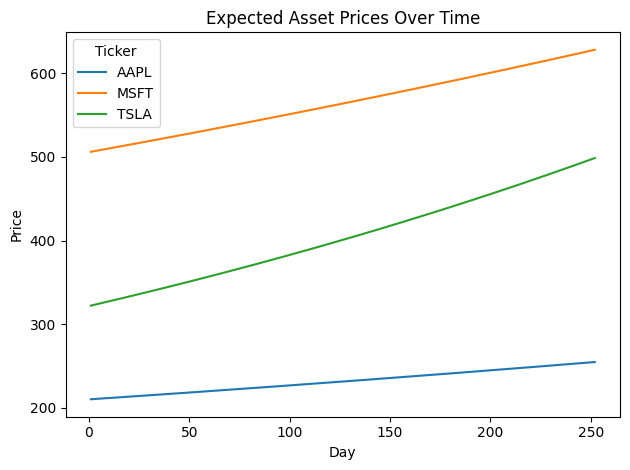

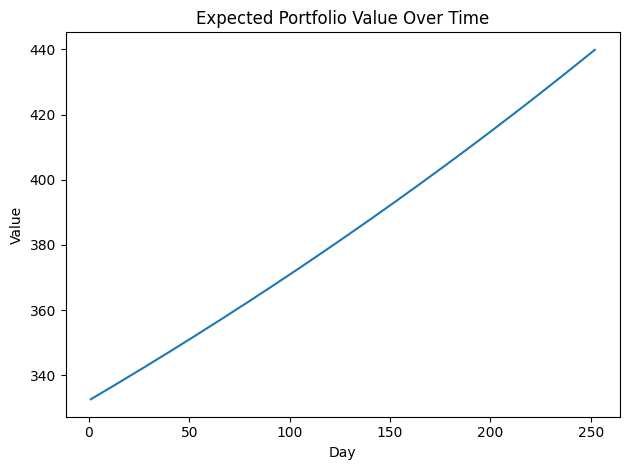

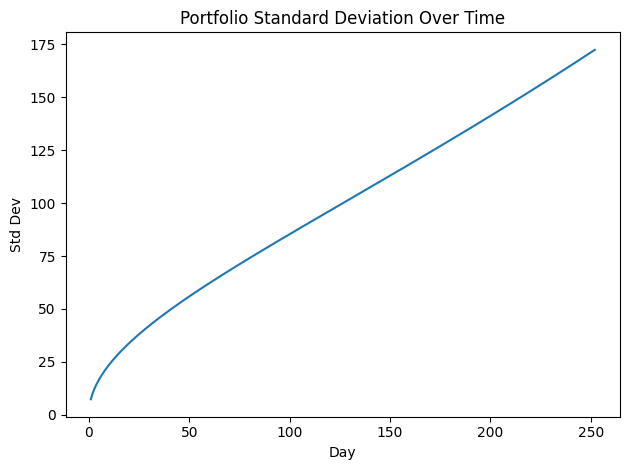

In [10]:
# Theoretical Expected Portfolio Values over Days

# Convert to numpy
init_px   = initial_prices.values
mu_ann    = mu.values * 252
sigma_ann = sigma.values * np.sqrt(252)
w         = weights
R         = corr_matrix.values
n         = init_px.size

# Time grid
dt         = 1/252
time_days  = np.arange(1, n_days+1)
time_grid  = time_days * dt

# Prepare storage
#  1. expected_px_ts: (n_days, n)
#  2. var_ts, std_ts, port_val_ts: (n_days,)
expected_px_ts = np.zeros((n_days, n))
var_ts         = np.zeros(n_days)
std_ts         = np.zeros(n_days)
port_val_ts    = np.zeros(n_days)

# Loop over each day
for idx, t in enumerate(time_grid):
    expected_px_ts[idx] = init_px * np.exp(mu_ann * t)

    cov_t = np.zeros((n, n))
    expo = np.exp(np.outer(mu_ann, np.ones(n))*t +
                  np.outer(np.ones(n), mu_ann)*t)

    vol_term = np.exp(R * np.outer(sigma_ann, sigma_ann) * t) - 1
    cov_t = np.outer(init_px, init_px) * expo * vol_term

    port_val_ts[idx] = w @ expected_px_ts[idx]
    var_ts[idx]      = w @ cov_t @ w
    std_ts[idx]      = np.sqrt(var_ts[idx])

# Pack into DataFrame for easy inspection
assets = initial_prices.index
df_px = pd.DataFrame(expected_px_ts,
                     index=pd.Index(time_days, name='Day'),
                     columns=assets)

df_port = pd.DataFrame({
    'Expected_Portfolio_Value': port_val_ts,
    'Portfolio_Variance':      var_ts,
    'Portfolio_StdDev':         std_ts,
}, index=df_px.index)

# Show the last few rows
print("=== Asset Expected Prices ===")
print(df_px.tail())
print("\n=== Portfolio Metrics ===")
print(df_port.tail())


# Plot

# All assets' expected prices over time
plt.figure()
df_px.plot(ax=plt.gca())
plt.title('Expected Asset Prices Over Time')
plt.xlabel('Day')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Expected portfolio value over time
plt.figure()
df_port['Expected_Portfolio_Value'].plot()
plt.title('Expected Portfolio Value Over Time')
plt.xlabel('Day')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

# Portfolio standard deviation over time
plt.figure()
df_port['Portfolio_StdDev'].plot()
plt.title('Portfolio Standard Deviation Over Time')
plt.xlabel('Day')
plt.ylabel('Std Dev')
plt.tight_layout()
plt.show()


In [8]:
print(f"Expected Final Portfolio Value: ${expected_value:.2f}")
print(f"Standard Deviation: ${std_dev:.2f}")
print(f"Value at Risk (95%): ${VaR_95:.2f}")
print(f"Conditional VaR (95%): ${CVaR_95:.2f}")

Expected Final Portfolio Value: $439.52
Standard Deviation: $169.95
Value at Risk (95%): $231.98
Conditional VaR (95%): $203.29
